### Flood prediction model ###

This aim for this "Regression with a Flood Prediction Dataset" competition is, as the title implies to construct a model or algorithm that can accurately predict whether or not an area is in risk of beeing flooded. The competition is part of the playground competition group that allows for easy entry into the Kaggle competitions with a simple dataset consisting of synthetic data that has been generated for the particular competition.<br>Being a regression problem the result should be a value rather than a class and the score metric used is $R^2$ which is 1 minus the residual sum of squares divided by the total sum of squares or $R^2 = 1 - \frac{RSS}{TSS}$.

First, import the dependencies / libraries.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tensorflow import keras
from scipy import stats

### EDA ###

We need to know a bit about the data we are working with.<br>
Let us do some Exploratory Data Analysis.

The training data is stored in one file and the test data by which our competition score is calculated is stored in another file.

In [17]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv')

If we take a look at the first and last row of the training data we get an idea of what values to expect.<br>
Pandas truncates columns if there are too many. We need to disable that to see all the features we have available.<br>
Looking at the data below we can see that we have 20 features to train the model on a corresponding target value. We can also see that it is a fairly large dataset consisting of more than 1.1 million rows.<br>
An interesting fact is that it seems that all training features are discrete values rather than continuous values. I assume the idea is that each feature simulates a score or evaluation. This is important as there is a big difference between a range of discrete values that means more or less something or a number of discrete values that refers to different categories (and thus can not be regarded as being "better or worse" or "more and less". If the latter was the case we would want to one-hot encode the feature values before training the models later.

In [18]:
pd.set_option('display.max_columns', None)

train_df

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5,0.415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117952,1117952,3,3,4,10,4,5,5,7,10,4,3,7,8,7,2,2,1,4,6,4,0.495
1117953,1117953,2,2,4,3,9,5,8,1,3,5,5,9,4,4,3,7,4,9,4,5,0.480
1117954,1117954,7,3,9,4,6,5,9,1,3,4,5,5,5,5,5,6,5,5,2,4,0.485
1117955,1117955,7,3,3,7,5,2,3,4,6,4,6,6,8,5,3,4,6,7,6,4,0.495


Describing the Pandas dataframe allows us to get a more detailed overview of the different features available. Particularly we want to make sure there are no placeholder values or null values for missing data. This being a synthetic dataset it seems very clean and well sorted. Something we probably cannot expect in all real-world scenarios.<br>
Also we see that all minimum values for the features are 0 and the maximum values are between 16 and 18. The result value is between 0.285 and 0.725.

In [19]:
train_df.describe()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,5.589780e+05,4.921450e+00,4.926671e+00,4.955322e+00,4.942240e+00,4.942517e+00,4.934093e+00,4.955878e+00,4.927791e+00,4.942619e+00,4.949230e+00,4.945239e+00,4.946893e+00,4.953999e+00,4.931376e+00,4.929032e+00,4.925907e+00,4.927520e+00,4.950859e+00,4.940587e+00,4.939004e+00,5.044803e-01
std,3.227265e+05,2.056387e+00,2.093879e+00,2.072186e+00,2.051689e+00,2.083391e+00,2.057742e+00,2.083063e+00,2.065992e+00,2.068545e+00,2.083324e+00,2.078141e+00,2.072333e+00,2.088899e+00,2.078287e+00,2.082395e+00,2.064813e+00,2.074176e+00,2.068696e+00,2.081123e+00,2.090350e+00,5.102610e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,2.794890e+05,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.700000e-01
50%,5.589780e+05,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.050000e-01
75%,8.384670e+05,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.400000e-01
max,1.117956e+06,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.700000e+01,1.800000e+01,1.900000e+01,1.600000e+01,1.600000e+01,7.250000e-01


A final check to make sure there are no null values.

In [20]:
train_df.isna().sum()

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

The histograms below show that all features seem to be more or less normally distributed (except they are discrete values as mentioned before) with a nice bell-shaped histogram which should make linear models a viable option and will in general make training easier.

array([[<Axes: title={'center': 'MonsoonIntensity'}>,
        <Axes: title={'center': 'TopographyDrainage'}>,
        <Axes: title={'center': 'RiverManagement'}>,
        <Axes: title={'center': 'Deforestation'}>,
        <Axes: title={'center': 'Urbanization'}>],
       [<Axes: title={'center': 'ClimateChange'}>,
        <Axes: title={'center': 'DamsQuality'}>,
        <Axes: title={'center': 'Siltation'}>,
        <Axes: title={'center': 'AgriculturalPractices'}>,
        <Axes: title={'center': 'Encroachments'}>],
       [<Axes: title={'center': 'IneffectiveDisasterPreparedness'}>,
        <Axes: title={'center': 'DrainageSystems'}>,
        <Axes: title={'center': 'CoastalVulnerability'}>,
        <Axes: title={'center': 'Landslides'}>,
        <Axes: title={'center': 'Watersheds'}>],
       [<Axes: title={'center': 'DeterioratingInfrastructure'}>,
        <Axes: title={'center': 'PopulationScore'}>,
        <Axes: title={'center': 'WetlandLoss'}>,
        <Axes: title={'center': '

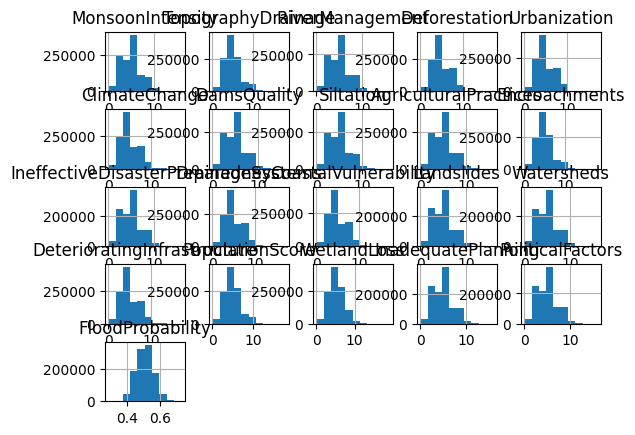

In [21]:
train_df.drop(['id'], axis=1).hist()

On the boxplots below with all the features we can see how similar they all are.<br>
It seems values above 10 for all features are rare and could be considered outliers<br>

<Axes: >

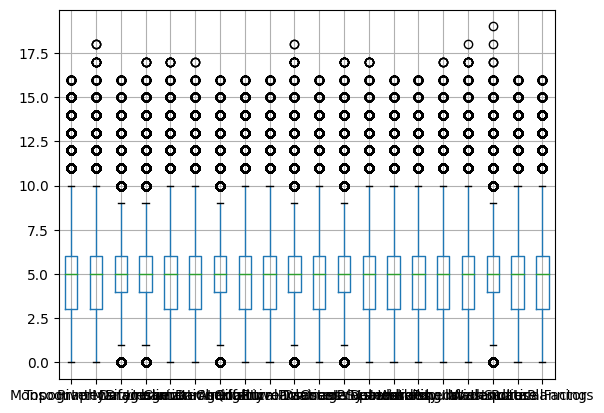

In [22]:
train_df.drop(['id', 'FloodProbability'], axis=1).boxplot()

The correlation plot below looks a bit odd. It seems that there is almost no simple correlation between any of the features except Floodprobability (luckily considering it's our target value) which has more or less the same correlation to all the features.

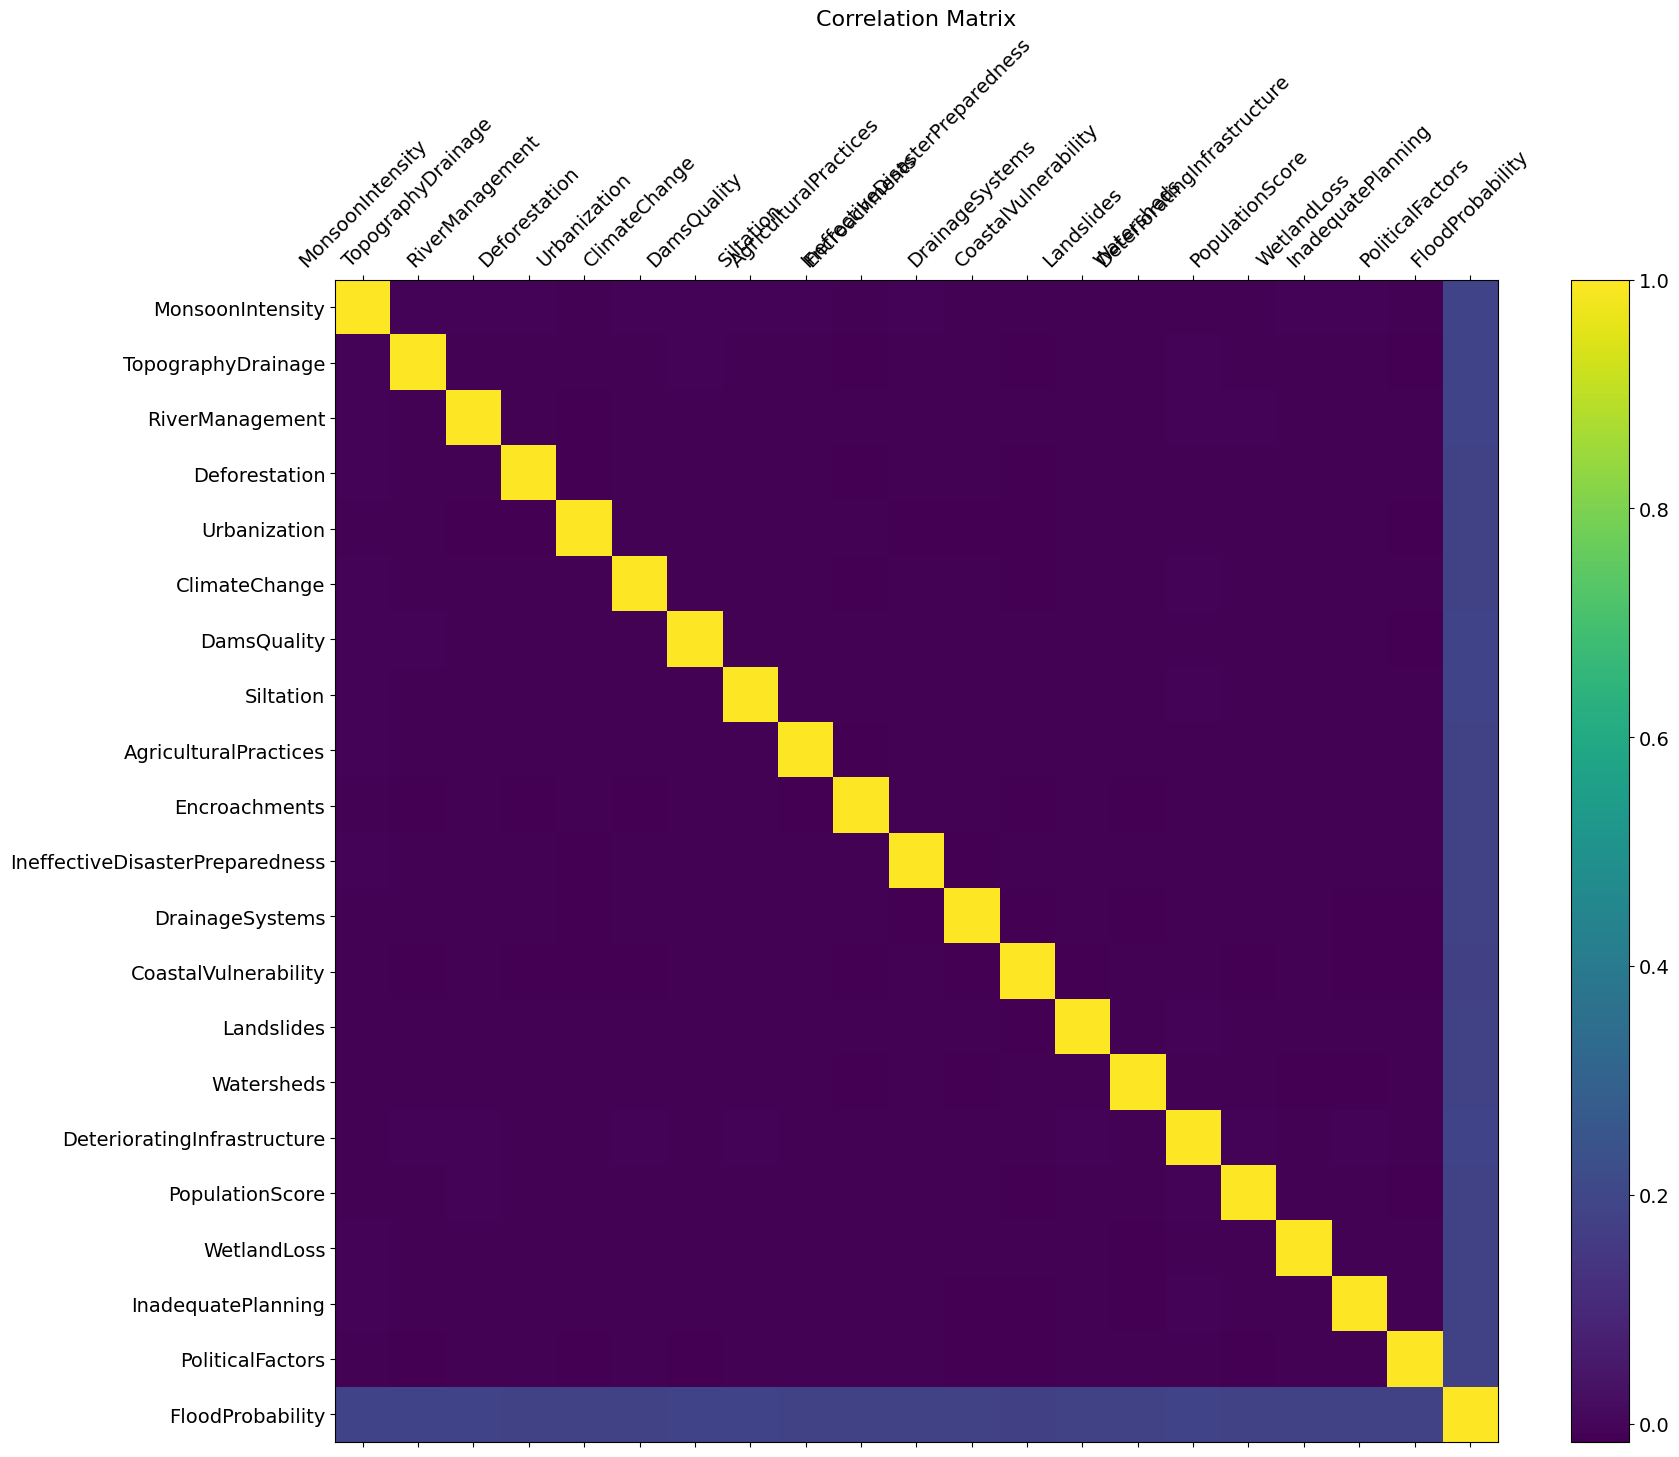

In [23]:
f = plt.figure(figsize=(19, 15))
plt.matshow(train_df.drop(['id'], axis=1).corr(), fignum=f.number)
plt.xticks(range(train_df.drop(['id'], axis=1).select_dtypes(['number']).shape[1]), train_df.drop(['id'], axis=1).select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(train_df.drop(['id'], axis=1).select_dtypes(['number']).shape[1]), train_df.drop(['id'], axis=1).select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

And below the correlations in numerical form which shows the same picture.<br>
As mentioned this looks a bit odd as there is usually some percieved correlation between some of the features but since this is a synthetic dataset it does not seem impossible.

In [24]:
train_df.drop(['id'], axis=1).corr()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
MonsoonIntensity,1.000000,-0.007362,-0.008070,-0.007251,-0.009309,-0.008031,-0.007787,-0.007836,-0.008232,-0.010309,-0.008032,-0.009716,-0.010659,-0.009121,-0.008900,-0.008486,-0.008679,-0.006811,-0.008155,-0.008474,0.189098
TopographyDrainage,-0.007362,1.000000,-0.009924,-0.008548,-0.010532,-0.009619,-0.007607,-0.009824,-0.009496,-0.012887,-0.010746,-0.010056,-0.012526,-0.010240,-0.011067,-0.006628,-0.010815,-0.010267,-0.011617,-0.012350,0.187635
RiverManagement,-0.008070,-0.009924,1.000000,-0.008574,-0.012292,-0.009237,-0.008711,-0.010058,-0.010783,-0.011615,-0.010675,-0.011277,-0.011680,-0.008994,-0.011412,-0.005827,-0.006727,-0.010069,-0.009673,-0.011550,0.187131
Deforestation,-0.007251,-0.008548,-0.008574,1.000000,-0.012248,-0.008266,-0.009356,-0.011536,-0.010039,-0.013175,-0.009512,-0.010490,-0.012388,-0.009257,-0.010671,-0.008862,-0.011777,-0.011004,-0.010424,-0.009661,0.184001
Urbanization,-0.009309,-0.010532,-0.012292,-0.012248,1.000000,-0.011199,-0.011128,-0.010153,-0.010559,-0.010784,-0.012685,-0.012572,-0.014497,-0.010582,-0.012107,-0.010656,-0.011485,-0.011023,-0.011584,-0.013005,0.180861
ClimateChange,-0.008031,-0.009619,-0.009237,-0.008266,-0.011199,1.000000,-0.008427,-0.009457,-0.011517,-0.012533,-0.011346,-0.009650,-0.013005,-0.009352,-0.009882,-0.006324,-0.010332,-0.009376,-0.010772,-0.011379,0.184761
DamsQuality,-0.007787,-0.007607,-0.008711,-0.009356,-0.011128,-0.008427,1.000000,-0.009401,-0.009033,-0.010890,-0.009515,-0.010439,-0.012096,-0.009924,-0.009085,-0.009831,-0.009599,-0.009372,-0.011374,-0.013081,0.187996
Siltation,-0.007836,-0.009824,-0.010058,-0.011536,-0.010153,-0.009457,-0.009401,1.000000,-0.010179,-0.010628,-0.009099,-0.010702,-0.011762,-0.009173,-0.009457,-0.006312,-0.008739,-0.008667,-0.009079,-0.008493,0.186789
AgriculturalPractices,-0.008232,-0.009496,-0.010783,-0.010039,-0.010559,-0.011517,-0.009033,-0.010179,1.000000,-0.012244,-0.010763,-0.010845,-0.011415,-0.010624,-0.009901,-0.008708,-0.008958,-0.011392,-0.010418,-0.011157,0.183366
Encroachments,-0.010309,-0.012887,-0.011615,-0.013175,-0.010784,-0.012533,-0.010890,-0.010628,-0.012244,1.000000,-0.012211,-0.011994,-0.016203,-0.011299,-0.013542,-0.010404,-0.010645,-0.010364,-0.012175,-0.011860,0.178841


### Data cleansing ###

Based on the above there does not seem to be a great need for any data cleansing.<br>
There were no null values or weird outliers to have to deal with, and there doesn't appear to be any simple correlations either.<br>
It probably won't affect the end result much to normalize the features as they are more or less scaled the same way all of them, but for good measure I will min-max scale them to be in the range 0 to 1.<br>
On the boxplot we noticed that from value 10 and up for all the features are outliers. Capping the values at 10 might have a better effect than merely scaling all values, so I will be exploring that in the models.<br>
Since we have to be careful to normalize the test data for the submission file in the exact same way as we do for the training file we will do both in the same cell.

In [25]:
for column in test_df.drop(['id'], axis=1).columns:
    test_df[column] = (test_df[column] - train_df[column].min()) / (train_df[column].max() - train_df[column].min())     

for column in train_df.drop(['id','FloodProbability'], axis=1).columns:
    train_df[column] = (train_df[column] - train_df[column].min()) / (train_df[column].max() - train_df[column].min())     

train_df.describe()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,5.589780e+05,3.075907e-01,2.737039e-01,3.097076e-01,2.907200e-01,2.907363e-01,2.902408e-01,3.097423e-01,3.079869e-01,3.089137e-01,2.749572e-01,3.090774e-01,2.909937e-01,2.914117e-01,3.082110e-01,3.080645e-01,2.897592e-01,2.737511e-01,2.605716e-01,3.087867e-01,3.086877e-01,5.044803e-01
std,3.227265e+05,1.285242e-01,1.163266e-01,1.295117e-01,1.206876e-01,1.225524e-01,1.210436e-01,1.301914e-01,1.291245e-01,1.292841e-01,1.157402e-01,1.298838e-01,1.219019e-01,1.228764e-01,1.298929e-01,1.301497e-01,1.214596e-01,1.152320e-01,1.088787e-01,1.300702e-01,1.306469e-01,5.102610e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,2.794890e+05,1.875000e-01,1.666667e-01,2.500000e-01,2.352941e-01,1.764706e-01,1.764706e-01,2.500000e-01,1.875000e-01,1.875000e-01,2.222222e-01,1.875000e-01,2.352941e-01,1.764706e-01,1.875000e-01,1.875000e-01,1.764706e-01,1.666667e-01,2.105263e-01,1.875000e-01,1.875000e-01,4.700000e-01
50%,5.589780e+05,3.125000e-01,2.777778e-01,3.125000e-01,2.941176e-01,2.941176e-01,2.941176e-01,3.125000e-01,3.125000e-01,3.125000e-01,2.777778e-01,3.125000e-01,2.941176e-01,2.941176e-01,3.125000e-01,3.125000e-01,2.941176e-01,2.777778e-01,2.631579e-01,3.125000e-01,3.125000e-01,5.050000e-01
75%,8.384670e+05,3.750000e-01,3.333333e-01,3.750000e-01,3.529412e-01,3.529412e-01,3.529412e-01,3.750000e-01,3.750000e-01,3.750000e-01,3.333333e-01,3.750000e-01,3.529412e-01,3.529412e-01,3.750000e-01,3.750000e-01,3.529412e-01,3.333333e-01,3.157895e-01,3.750000e-01,3.750000e-01,5.400000e-01
max,1.117956e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.250000e-01


In order to judge the quality of the model I split up the data so that the same data is not used both for training and evaluating.<br>
Obviously choosing the size of the testset is a tradeoff between how much data we can afford to loose and how sure we want to be that the testset is representative of the data our model will encounter. Since this is a big dataset it does not seem to matter much and I have chosen to use 10% for the test dataset.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['id','FloodProbability'], axis=1), train_df['FloodProbability'], test_size=0.1, random_state=42)

Let us make a simple, linear model to use as a reference model. Hopefully the more advanced models will do better than that.

In [27]:
baseline_lm = LinearRegression().fit(X=X_train, y=y_train)

In [28]:
baseline_lm.score(X_test, y_test)

0.8452627166353617

Now we know that with this data we get 0.845 in $R^2$ score which seems like a good score which is at the time of writing somewhere in the middle of the field for the leaderboard on the Kaggle competition (assuming our test data can get the same accuracy), however this is dependent on the nature of the problem and we will have to explore more models in order to determine if that is good.

Below is a deep model. The data appears to be very uncomplicated so I want to try a very small and simple model with dropout trained for just one epoch in order to avoid overfitting.
Being a continuous target value we want to predict I will use Mean Squared Error as the loss and here I use a sigmoid activation function on the last layer since the result values are all in the 0 to 1 range.<br>
I have also decided to use the Adam optimizer as, in theory at least, it should converge faster than stochastic gradient descent.

In [29]:
dropout_level = 0.5

model = keras.models.Sequential()
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer, loss='MSE')

In [30]:
model.fit(X_train, y_train, epochs=3)

Epoch 1/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - loss: 0.0028
Epoch 2/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step - loss: 0.0020
Epoch 3/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 83s 2ms/step - loss: 0.0015


Below we can see that it reaches an $R^2$ score of just 0.003 which is terrible. We need to experiment with some changes to the model.

In [31]:
y_pred = model.predict(X_test)
metric = keras.metrics.R2Score()
metric.update_state(y_test, y_pred)
result = metric.result()
print(result)

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
tf.Tensor(0.0029203296, shape=(), dtype=float32)


Below I have made two changes; I have added batch normalization and I have changed the last activation function from sigmoid to None which means it is linear.

In [35]:
dropout_level = 0.5

model = keras.models.Sequential()
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(1, activation=None))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer, loss='MSE')

In [36]:
model.fit(X_train, y_train, epochs=3)

Epoch 1/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 1.0235
Epoch 2/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 0.0011
Epoch 3/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 141s 3ms/step - loss: 9.5481e-04


As we can see on the $R^2$ score below we are now at 0.8 which is a huge improvement compared to our first deep model. We are moving in the right direction!

In [37]:
y_pred = model.predict(X_test)
metric = keras.metrics.R2Score()
metric.update_state(y_test, y_pred)
result = metric.result()
print(result)

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
tf.Tensor(0.8032298, shape=(), dtype=float32)


Below I have added a Gaussian noise layer that adds a small amount of noise to the input signal to further try to prevent overfitting.<br>

In [38]:
dropout_level = 0.5

model = keras.models.Sequential()
model.add(keras.layers.GaussianNoise(0.05))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(1, activation=None))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer, loss='MSE')

In [39]:
model.fit(X_train, y_train, epochs=3)

Epoch 1/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 138s 3ms/step - loss: 0.7426
Epoch 2/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 0.0014
Epoch 3/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 0.0012


As we can see on the $R^2$ score below, adding an additional gausian noise layer does not improve accurace. On the contrary, accuracy degrades with the additional layer.

In [40]:
y_pred = model.predict(X_test)
metric = keras.metrics.R2Score()
metric.update_state(y_test, y_pred)
result = metric.result()
print(result)

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
tf.Tensor(0.74027383, shape=(), dtype=float32)


Let us revert to the previous model and try with stochastic gradient descent instead of Adam.

In [41]:
dropout_level = 0.5

model = keras.models.Sequential()
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(1, activation=None))

optimizer = keras.optimizers.SGD(learning_rate=0.0001)
model.compile(optimizer, loss='MSE')

In [42]:
model.fit(X_train, y_train, epochs=3)

Epoch 1/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - loss: 0.6271
Epoch 2/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 64s 2ms/step - loss: 0.0026
Epoch 3/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 0.0026


As we can see on the $R^2$ score below that does not seem to work at all!

In [43]:
y_pred = model.predict(X_test)
metric = keras.metrics.R2Score()
metric.update_state(y_test, y_pred)
result = metric.result()
print(result)

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
tf.Tensor(0.026803553, shape=(), dtype=float32)


Of course that might be because the last layer, being linear, is outputting values outside of the target range of roughly 0.25 to 0.75. Let is try to clip the values at that and see if it helps.<br>
The result is the same. That is not the problem.

In [44]:
metric = keras.metrics.R2Score()
metric.update_state(y_test, np.clip(y_pred, 0.25, 0.75))
result = metric.result()
print(result)

tf.Tensor(0.026803553, shape=(), dtype=float32)


Maybe the problem is that our model is not deep enough! Let us add some more layers and try again.

In [46]:
dropout_level = 0.5

model = keras.models.Sequential()
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(1, activation=None))

optimizer = keras.optimizers.SGD(learning_rate=0.0001)
model.compile(optimizer, loss='MSE')

In [47]:
model.fit(X_train, y_train, epochs=3)

Epoch 1/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - loss: 0.3117
Epoch 2/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - loss: 0.0026
Epoch 3/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - loss: 0.0026


Same result. SGD does not seem to work well in this case.

In [48]:
y_pred = model.predict(X_test)
metric = keras.metrics.R2Score()
metric.update_state(y_test, y_pred)
result = metric.result()
print(result)

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
tf.Tensor(0.00070798397, shape=(), dtype=float32)


For good measure. Let us try with no dropout on the previously most effective deep model (using Adam optimizer and batchnormalization).

In [49]:
dropout_level = 0.0

model = keras.models.Sequential()
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(1, activation=None))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer, loss='MSE')

In [50]:
model.fit(X_train, y_train, epochs=3)

Epoch 1/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - loss: 0.0848
Epoch 2/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 85s 2ms/step - loss: 5.6246e-04
Epoch 3/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step - loss: 5.3210e-04


On the below score we can see that we got 0.848 which is our best result yet. That does not indicate that overfitting is a problem with our little model.

In [51]:
y_pred = model.predict(X_test)
metric = keras.metrics.R2Score()
metric.update_state(y_test, y_pred)
result = metric.result()
print(result)

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
tf.Tensor(0.84813666, shape=(), dtype=float32)


Since the result above did not indicate overfitting let us try with a larger model. An additional layer, more nodes in each layer and no dropout.

In [54]:
dropout_level = 0.0

model_large = keras.models.Sequential()
model_large.add(keras.layers.BatchNormalization())
model_large.add(keras.layers.Dense(64, activation='relu'))
model_large.add(keras.layers.BatchNormalization())
model_large.add(keras.layers.Dropout(dropout_level))
model_large.add(keras.layers.Dense(64, activation='relu'))
model_large.add(keras.layers.BatchNormalization())
model_large.add(keras.layers.Dropout(dropout_level))
model_large.add(keras.layers.Dense(32, activation='relu'))
model_large.add(keras.layers.BatchNormalization())
model_large.add(keras.layers.Dropout(dropout_level))
model_large.add(keras.layers.Dense(16, activation='relu'))
model_large.add(keras.layers.BatchNormalization())
model_large.add(keras.layers.Dropout(dropout_level))
model_large.add(keras.layers.Dense(1, activation=None))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_large.compile(optimizer, loss='MSE')

In [55]:
model_large.fit(X_train, y_train, epochs=3)

Epoch 1/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - loss: 0.1761
Epoch 2/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - loss: 6.0579e-04
Epoch 3/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 89s 3ms/step - loss: 5.5313e-04


On the score below we see accuracy is decreasing slightly. There does not seem to be much gained in increasing the size of the network.

In [56]:
y_pred = model_large.predict(X_test)
metric = keras.metrics.R2Score()
metric.update_state(y_test, y_pred)
result = metric.result()
print(result)

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
tf.Tensor(0.84438527, shape=(), dtype=float32)


Let us make a submission file with the model that performed best so far.

In [57]:
submission_df = pd.DataFrame()

submission_df['id'] = test_df['id']
submission_df['FloodProbability'] = model.predict(test_df.drop(['id'], axis=1))

submission_df.to_csv('submission.csv', index=False)

23291/23291 ━━━━━━━━━━━━━━━━━━━━ 30s 1ms/step


Of course we could upload this file and claim we are done now. However there are a few more things I want to explore. First; remember we noticed that values above 10 in the features were more or less outliers? What if we clip the values at 10 and then normalize the data?

In [58]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv')

In [59]:
clipped_train_df = train_df.drop(['id'], axis=1).clip(0, 10)
clipped_test_df = test_df.drop(['id'], axis=1).clip(0, 10)

In [60]:
for column in test_df.drop(['id'], axis=1).columns:
    clipped_test_df[column] = (clipped_test_df[column] - clipped_train_df[column].min()) / (clipped_train_df[column].max() - clipped_train_df[column].min())     

for column in train_df.drop(['id','FloodProbability'], axis=1).columns:
    clipped_train_df[column] = (clipped_train_df[column] - clipped_train_df[column].min()) / (clipped_train_df[column].max() - clipped_train_df[column].min())     

clipped_train_df.describe()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,4.908191e-01,4.913345e-01,4.942742e-01,4.929734e-01,4.929380e-01,4.921946e-01,4.941943e-01,4.914895e-01,4.930366e-01,4.935786e-01,4.932707e-01,4.933205e-01,4.939933e-01,4.918990e-01,4.915877e-01,4.913516e-01,4.914456e-01,4.938061e-01,4.927474e-01,4.925800e-01,5.044803e-01
std,2.016102e-01,2.054451e-01,2.034865e-01,2.014048e-01,2.044283e-01,2.021329e-01,2.041989e-01,2.027252e-01,2.032215e-01,2.043485e-01,2.040911e-01,2.031445e-01,2.047521e-01,2.041501e-01,2.043215e-01,2.027771e-01,2.035186e-01,2.030644e-01,2.042108e-01,2.051600e-01,5.102610e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,3.000000e-01,3.000000e-01,4.000000e-01,4.000000e-01,3.000000e-01,3.000000e-01,4.000000e-01,3.000000e-01,3.000000e-01,4.000000e-01,3.000000e-01,4.000000e-01,3.000000e-01,3.000000e-01,3.000000e-01,3.000000e-01,3.000000e-01,4.000000e-01,3.000000e-01,3.000000e-01,4.700000e-01
50%,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.050000e-01
75%,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01,6.000000e-01,5.400000e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.250000e-01


As we can see above the feature values are again between 0 and 1. In order to follow the same procedure as we used before I again split the file into 90% train and 10% test (which is really 10% validation but that doesn't matter).

In [61]:
X_train, X_test, y_train, y_test = train_test_split(clipped_train_df.drop(['FloodProbability'], axis=1), clipped_train_df['FloodProbability'], test_size=0.1, random_state=42)

And then train on our previously most succesful model.

In [63]:
dropout_level = 0.0

model = keras.models.Sequential()
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(1, activation=None))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer, loss='MSE')

In [64]:
model.fit(X_train, y_train, epochs=3)

Epoch 1/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step - loss: 0.2094
Epoch 2/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 75s 2ms/step - loss: 5.7958e-04
Epoch 3/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step - loss: 5.4268e-04


As we can see on the score below it did not harm accuracy (much) but it didn't improve it either.

In [65]:
y_pred = model.predict(X_test)
metric = keras.metrics.R2Score()
metric.update_state(y_test, y_pred)
result = metric.result()
print(result)

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
tf.Tensor(0.84520423, shape=(), dtype=float32)


What about using weight decay and use exponential moving averages then?

In [66]:
dropout_level = 0.0

model = keras.models.Sequential()
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(1, activation=None))

optimizer = keras.optimizers.Adam(learning_rate=0.0001, weight_decay=0.001, use_ema=True)
model.compile(optimizer, loss='MSE')

In [67]:
model.fit(X_train, y_train, epochs=3)

Epoch 1/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - loss: 0.1466
Epoch 2/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 5.7528e-04
Epoch 3/3
31443/31443 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - loss: 5.4232e-04


As we can see on the score below this model does slightly worse.

In [36]:
y_pred = model.predict(X_test)
metric = keras.metrics.R2Score()
metric.update_state(y_test, y_pred)
result = metric.result()
print(result)

3494/3494 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
tf.Tensor(0.795802, shape=(), dtype=float32)


The way I have used the training and test set here in this exploration is a bit odd. Normally one would specify the validation set in the fit call to see epoch by epoch if the validation score suddenly detoriates as that is a clear indication of overfitting. I have chosen not to do so above to keep it consistent.<br>
One final thing I would like to try is to use the previously best model with the full training set except 0.01% and train it on the training data without normalizing the features first. I will use that for a final submission and see how that works.

In [69]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv')

In [70]:
dropout_level = 0.0

model = keras.models.Sequential()
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout_level))
model.add(keras.layers.Dense(1, activation=None))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer, loss='MSE')

model.fit(train_df.drop(['id', 'FloodProbability'], axis=1), train_df['FloodProbability'], validation_split=0.001, epochs=5)

Epoch 1/5
34902/34902 ━━━━━━━━━━━━━━━━━━━━ 75s 2ms/step - loss: 0.0878 - val_loss: 4.3092e-04
Epoch 2/5
34902/34902 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step - loss: 5.7146e-04 - val_loss: 4.1149e-04
Epoch 3/5
34902/34902 ━━━━━━━━━━━━━━━━━━━━ 83s 2ms/step - loss: 5.3574e-04 - val_loss: 4.0825e-04
Epoch 4/5
34902/34902 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step - loss: 5.2984e-04 - val_loss: 4.0185e-04
Epoch 5/5
34902/34902 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 5.2016e-04 - val_loss: 4.0639e-04


There appeared to be no overfitting above (that would could see from the validation loss at least). Final step is to create a submission file and submit that to the competition.<br>

In [71]:
submission_df = pd.DataFrame()

submission_df['id'] = test_df['id']
submission_df['FloodProbability'] = model.predict(test_df.drop(['id'], axis=1))

submission_df.to_csv('submission.csv', index=False)

23291/23291 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step


### Conclusion and Final remarks ###

The last file scores just below 0.85 as a late submission to the competition (0.848) and thus did ok but not spectacularly.<br>
So in the end it seems that the deep neural networks did in fact not do much better in this challenge than the simple linear model. The data simply does not seem to be sufficiently complex to warrant the use of more sophisticated models. Obviously there are countless ways a deep model can be built and trained and it might well be that some models could do significantly better than the ones I have explored here.<br>
That said simpler, more easily explainable models that are faster to train seem like they might be the preferred choice for this particular problem.<br>
If I did want to explore further with the use of deep learning for this problem though, I would probably want to look more into the effect of using different optimizer settings, as we saw that changing from Adam to SGD had a very large impact on the results. One might also want to look into preventing overfitting by using various regularization and dropout configurations.